[INFO] TDL010: using PAP column 'PAP_on_VoltageApnea (mmHg)'
[INFO] TDL012: using PAP column 'PAP_on_VoltageApnea (mmHg)'
[INFO] TDL013: using PAP column 'PAP_on_VoltageApnea (mmHg)'
[INFO] TDL014: using PAP column 'PAP_on_VoltageApnea (mmHg)'
[INFO] TDL015: using PAP column 'PAP_on_VoltageApnea (mmHg)'
[INFO] TDL016: using PAP column 'PAP_on_VoltageApnea (mmHg)'
Loaded 6 PAP series: ['TDL010', 'TDL012', 'TDL013', 'TDL014', 'TDL015', 'TDL016']
Patient splits ->
  train: ['TDL012', 'TDL016', 'TDL015', 'TDL014', 'TDL010']
  val  : ['TDL013']

Validation per-patient:
Val — TDL013: T=9316 | PAP raw mean=26.208 std=3.361


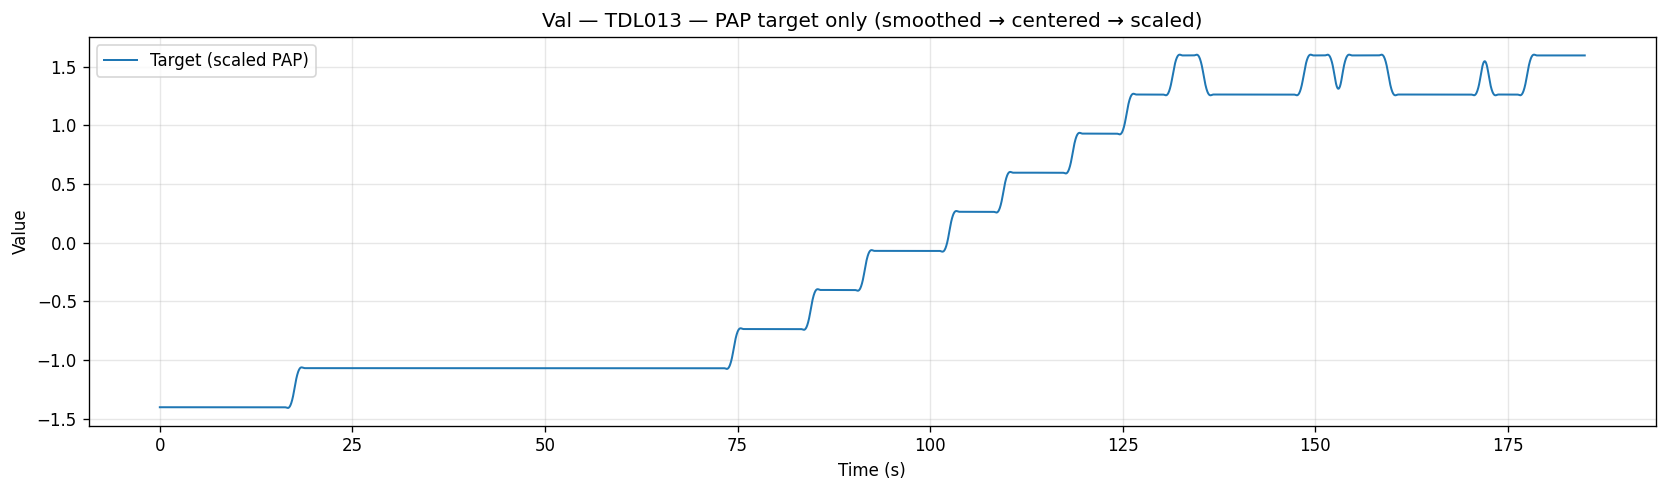


Training per-patient:
Train — TDL010: T=9316 | PAP raw mean=21.324 std=3.245


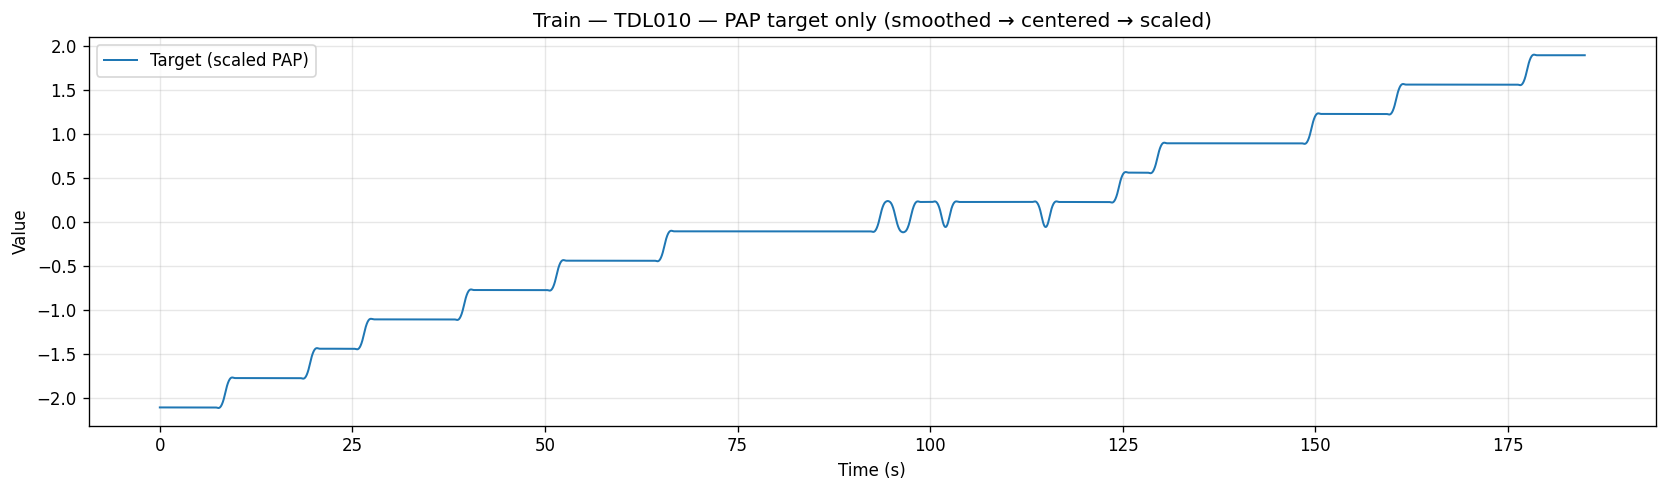

Train — TDL012: T=9064 | PAP raw mean=34.069 std=1.646


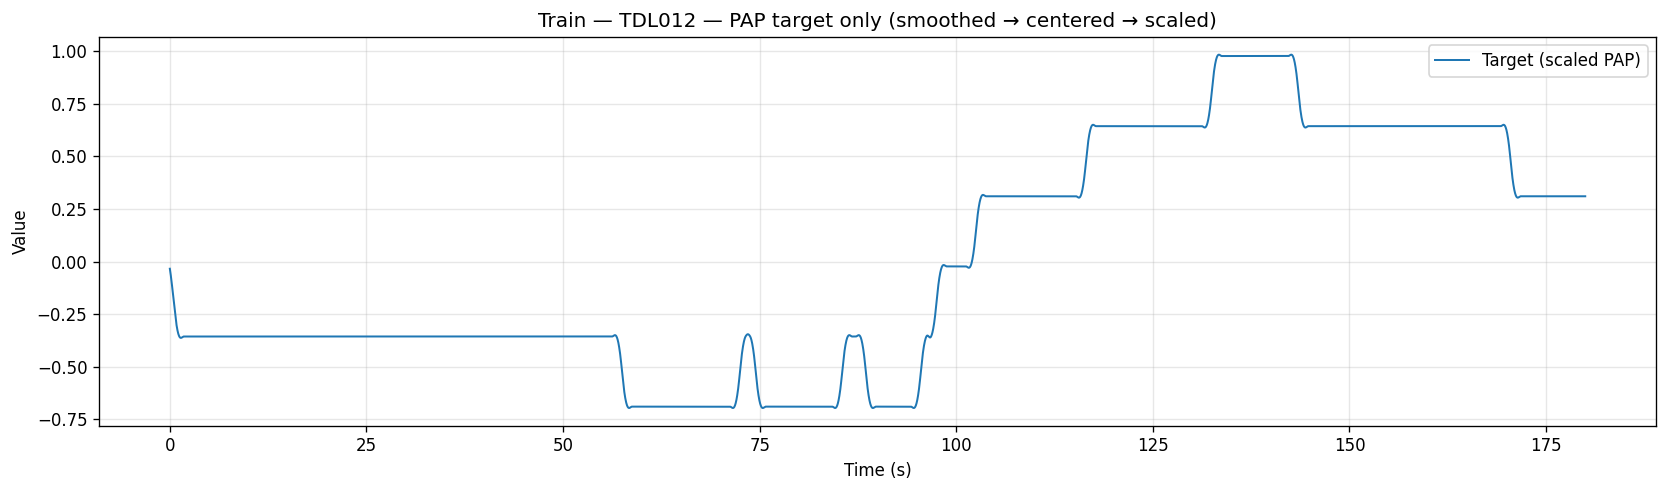

Train — TDL014: T=9064 | PAP raw mean=15.019 std=1.911


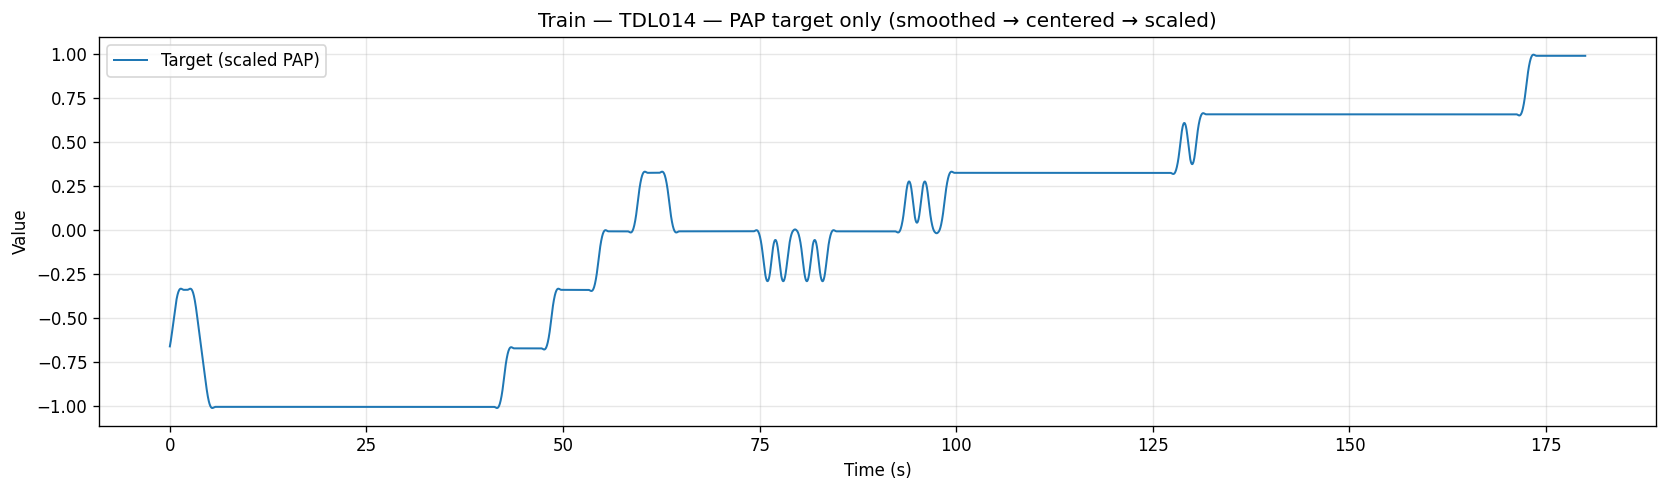

Train — TDL015: T=7553 | PAP raw mean=20.699 std=2.455


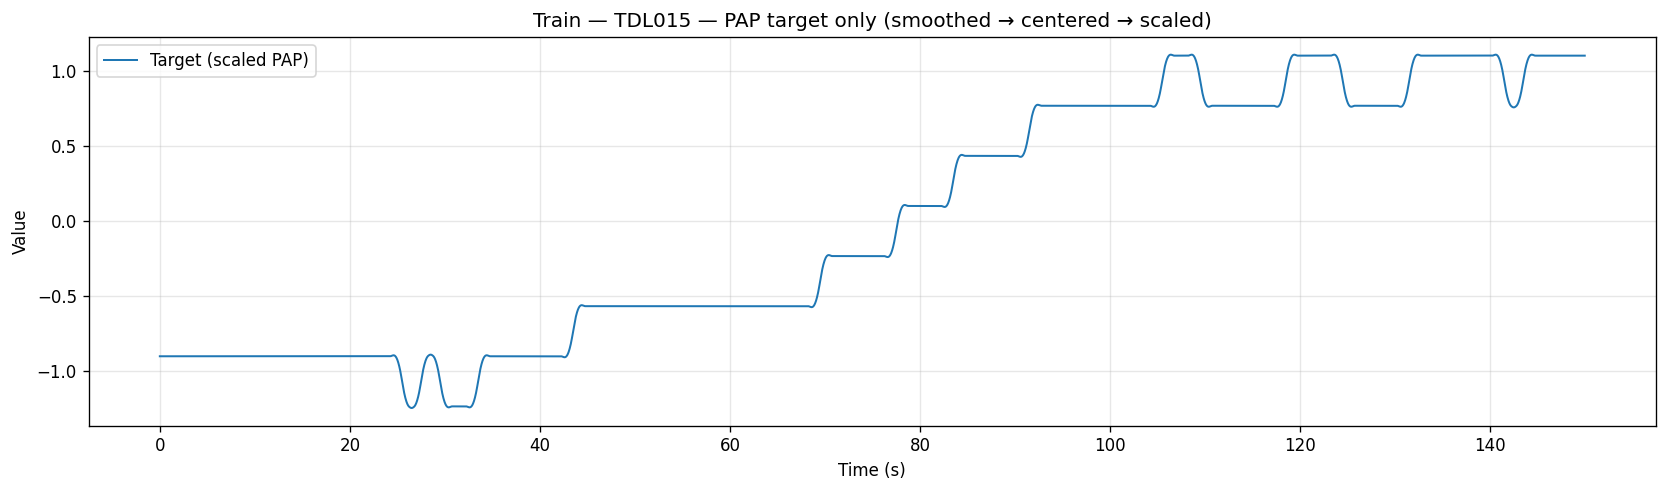

Train — TDL016: T=9064 | PAP raw mean=27.077 std=4.653


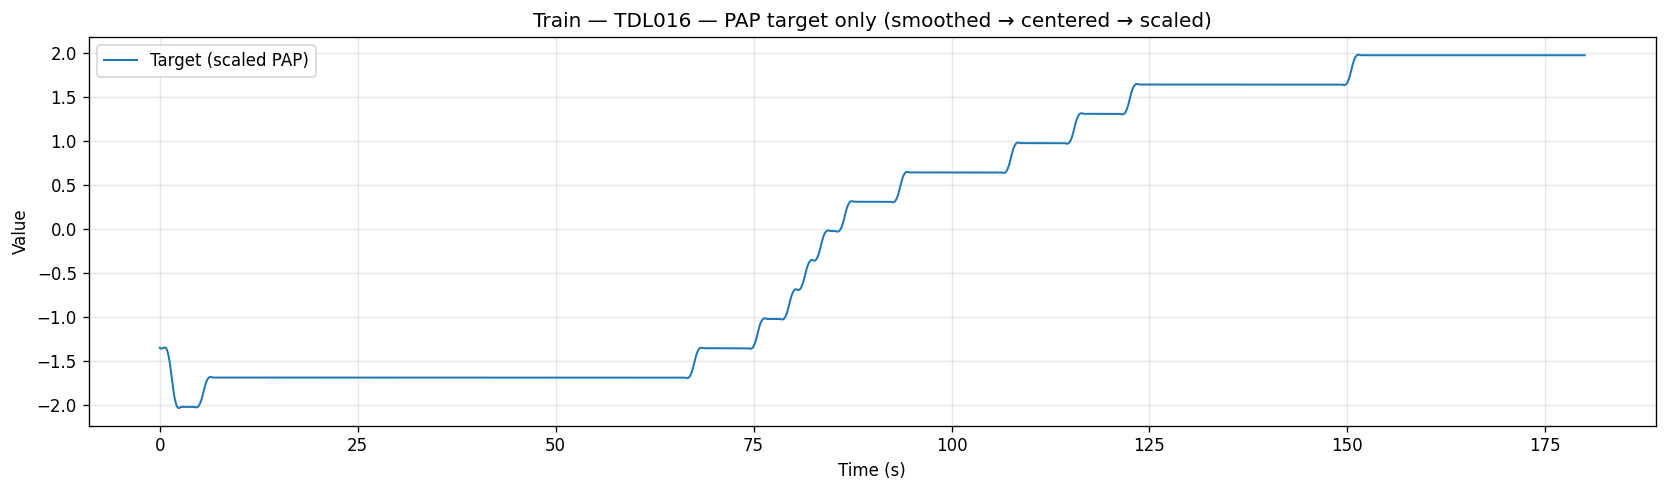

In [1]:
# =============================================================================
# PAP-ONLY DATA VIEW — Load PAP, build target exactly as in SCRIPT 3.1,
# and plot per-patient time series (no voltage, no model, no inference).
# =============================================================================

import os, time, random
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter

DEBUG = True
SEED  = 123

# --------------------------- Determinism (lite) ------------------------------
def set_deterministic(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
set_deterministic(SEED)

# --------------------------- Trend / smoothing -------------------------------
def make_trend(y: np.ndarray, win=81, poly=3) -> np.ndarray:
    """Savitzky–Golay trend with a small median prefilter (as in training)."""
    win = int(win)
    if win % 2 == 0: win += 1
    if win <= poly:  win = poly + 2 + (poly % 2 == 0)

    y_med = pd.Series(y).rolling(11, center=True, min_periods=1).median().to_numpy()
    y_tr  = savgol_filter(y_med, window_length=win, polyorder=poly, mode="interp")
    return y_tr.astype(np.float32)

# ------------------------------ CSV I/O (robust) -----------------------------
def _read_csv_basic(path: str, **kwargs) -> pd.DataFrame:
    return pd.read_csv(path, **kwargs)

def _sniff_delimiter(path: str) -> str:
    try:
        with open(path, "r", errors="ignore") as f:
            head = f.read(4096)
        commas = head.count(","); semis = head.count(";"); tabs = head.count("\t")
        if max(commas, semis, tabs) == 0: return ","
        return ";" if semis >= max(commas, tabs) else ("\t" if tabs > commas else ",")
    except Exception:
        return ","

def _to_numeric_best(s: pd.Series) -> np.ndarray:
    a = pd.to_numeric(s, errors="coerce")
    try:
        b = pd.to_numeric(s.astype(str).str.replace(",", ".", regex=False), errors="coerce")
    except Exception:
        b = a
    a_valid = int(np.isfinite(a).sum()); b_valid = int(np.isfinite(b).sum())
    best = b if b_valid > a_valid else a
    return best.to_numpy(dtype=np.float32)

def _read_pap_csv_robust(path: str) -> pd.DataFrame:
    try:
        df = _read_csv_basic(path, sep=None, engine="python")
        if df.shape[1] >= 1: return df
    except Exception: pass
    delim = _sniff_delimiter(path)
    try:
        df = _read_csv_basic(path, sep=delim)
        if df.shape[1] >= 1: return df
    except Exception: pass
    try:
        return _read_csv_basic(path, dtype=str, sep=None, engine="python")
    except Exception as e:
        raise RuntimeError(f"Failed to read PAP CSV: {path} → {e}")

# ------------------------------- PAP column pick -----------------------------
def _pick_pap_series(pap_df: pd.DataFrame, *, pid: str = "") -> np.ndarray:
    """
    Prefer columns containing: pap_on_voltage_apnea, pap_on_eit, pap, perfusion, pressure.
    Otherwise choose the column with the best numeric-valid ratio (≥ 0.2).
    """
    preferred = ["pap_on_voltage_apnea", "pap_on_eit", "pap", "perfusion", "pressure"]
    drop_like = {"time", "time_s", "t", "index", "unnamed: 0", "patientid", "id"}

    for col in pap_df.columns:
        name = str(col).lower()
        if any(k in name for k in preferred):
            s_num = _to_numeric_best(pap_df[col])
            if np.isfinite(s_num).sum() > 0:
                if DEBUG: print(f"[INFO] {pid}: using PAP column '{col}'")
                return s_num

    best_col, best_ratio, best_series = None, -1.0, None
    for col in pap_df.columns:
        if str(col).lower() in drop_like: continue
        s_num = _to_numeric_best(pap_df[col])
        if s_num.size == 0: continue
        ratio = np.isfinite(s_num).sum() / s_num.size
        if ratio > best_ratio:
            best_col, best_ratio, best_series = col, ratio, s_num

    if best_series is not None and best_ratio >= 0.2:
        if DEBUG: print(f"[INFO] {pid}: fallback PAP column '{best_col}' (ratio={best_ratio:.2f})")
        return best_series

    raise ValueError("No suitable numeric PAP column found.")

# --------------------------- Loading PAP patients ----------------------------
def _canon_id_from_pap(fname: str) -> str:
    stem = os.path.splitext(os.path.basename(fname))[0]
    for suf in ["_pap_on_voltage_apnea","_pap_on_eit","_pap_upsampled","_pap","-pap","_perfusion","-perfusion"]:
        if stem.endswith(suf): return stem[: -len(suf)]
    return stem

def load_pap_patients_from_folder(pap_folder: str) -> List[Tuple[str, Dict[str, np.ndarray]]]:
    """
    Returns: list of (patient_id, {'pap': pap_raw})
    """
    files = [f for f in os.listdir(pap_folder) if f.lower().endswith(".csv")]
    if not files:
        raise RuntimeError(f"No CSV files in {pap_folder}")

    patients: List[Tuple[str, Dict[str, np.ndarray]]] = []
    for f in sorted(files):
        pid = _canon_id_from_pap(f)
        path = os.path.join(pap_folder, f)
        try:
            df  = _read_pap_csv_robust(path)
            pap = _pick_pap_series(df, pid=pid).astype(np.float32)
            if len(pap) < 2:
                print(f"[WARN] Skipping {pid}: too few samples.")
                continue
            patients.append((pid, {"pap": pap}))
        except Exception as e:
            print(f"[WARN] {pid} skipped: {e}")
    print(f"Loaded {len(patients)} PAP series:", [p[0] for p in patients])
    return patients

# --------------------------- Split & scaler (train labels) -------------------
def split_patients_2way(patients, val_fraction=0.1, seed=42):
    pids = np.array([pid for pid, _ in patients])
    rng = np.random.default_rng(seed)
    perm = rng.permutation(len(pids))
    n_val = int(round(len(pids) * max(0.0, min(1.0, float(val_fraction)))))
    return pids[perm[n_val:]].tolist(), pids[perm[:n_val]].tolist()

def build_pap_scaler(patients, train_pids, trend_win: int, center_per_patient: bool = False) -> StandardScaler:
    ys = []
    trset = set(train_pids)
    for pid, d in patients:
        if pid in trset:
            y = d["pap"].astype(np.float32)
            y = make_trend(y, win=trend_win, poly=3)
            if center_per_patient: y = y - float(y.mean())
            ys.append(y)
    if not ys:  # fallback if train set ended up empty
        for _, d in patients:
            y = d["pap"].astype(np.float32)
            y = make_trend(y, win=trend_win, poly=3)
            if center_per_patient: y = y - float(y.mean())
            ys.append(y)
    y_all = np.concatenate(ys, axis=0).reshape(-1, 1)
    return StandardScaler().fit(y_all)

# ----------------------------- Plotting (PAP only) ---------------------------
def eval_pap_per_patient(patients, pid_list, *, fs: float, trend_win: int,
                         y_scaler: StandardScaler, center_per_patient: bool = True,
                         title_prefix: str = ""):
    sel = set(pid_list)
    for pid, d in patients:
        if pid not in sel: continue

        pap_raw = d["pap"].astype(np.float32)
        pap_tr  = make_trend(pap_raw, win=trend_win, poly=3)
        if center_per_patient:
            pap_tr = pap_tr - float(pap_tr.mean())
        pap_z   = y_scaler.transform(pap_tr.reshape(-1,1)).ravel().astype(np.float32)

        print(f"{title_prefix}{pid}: T={len(pap_raw)} | PAP raw mean={pap_raw.mean():.3f} std={pap_raw.std():.3f}")

        t = np.arange(len(pap_z)) / fs
        plt.figure(figsize=(14, 4.2), dpi=120)
        plt.title(f"{title_prefix}{pid} — PAP target only (smoothed → centered → scaled)")
        plt.plot(t, pap_z, label="Target (scaled PAP)", linewidth=1.2)
        plt.xlabel("Time (s)"); plt.ylabel("Value"); plt.legend()
        plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# =============================================================================
# MAIN — PAP only (no voltage)
# =============================================================================
if __name__ == "__main__":
    # 1) Input folder with PAP aligned/upsampled to voltage rate
    pap_folder = r"data_displaid_tidal\data_tilda_transformed\Data pap apnea upscaled"
    if not os.path.isdir(pap_folder):
        raise FileNotFoundError(f"Folder not found: {pap_folder}")

    # 2) Load PAP series
    patients = load_pap_patients_from_folder(pap_folder)
    if not patients:
        raise RuntimeError("No PAP patients found.")

    # 3) Patient split (train/val) — randomized per run (as in your script)
    train_p, val_p = split_patients_2way(
        patients,
        val_fraction=0.10,
        seed=int(time.time())  # unique seed per run
    )
    print("Patient splits ->"); print("  train:", train_p); print("  val  :", val_p)

    # 4) Timing & trend (keep consistent with your label pipeline)
    FS = 50.355           # sampling rate of PAP (upsampled)
    BEAT_SEC = 1.5
    TREND_WIN = (int(round(FS * BEAT_SEC)) | 1)  # ensure odd
    CENTER_PER_PATIENT = True

    # 5) y-scaler fit on TRAIN patients (exactly as in training)
    pap_scaler = build_pap_scaler(
        patients, train_p, trend_win=TREND_WIN, center_per_patient=CENTER_PER_PATIENT
    )

    # ---------------------------- "Printed here" blocks -----------------------
    print("\nValidation per-patient:")
    eval_pap_per_patient(
        patients, val_p, fs=FS, trend_win=TREND_WIN,
        y_scaler=pap_scaler, center_per_patient=CENTER_PER_PATIENT,
        title_prefix="Val — "
    )

    print("\nTraining per-patient:")
    eval_pap_per_patient(
        patients, train_p, fs=FS, trend_win=TREND_WIN,
        y_scaler=pap_scaler, center_per_patient=CENTER_PER_PATIENT,
        title_prefix="Train — "
    )
